In [1]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

from tqdm import tqdm

In [15]:
import os
import sys
import gzip
import random
import platform
import warnings
import collections
from tqdm import tqdm, tqdm_notebook

import re
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.datasets import load_iris

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torchvision.transforms.functional import to_pil_image


In [36]:
transform = transforms.Compose([
    Resize((256, 192), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)),
])


In [ ]:
labeled_csv = pd.read_csv('input/data/train/image_label.csv')

In [ ]:
len(labeled_csv)

18900

In [37]:
class TrainDataset(Dataset):
    def __init__(self, table, transform):
        self.table = table
        self.transform = transform

        self.X, self.y = self.read_data()
        
    def read_data(self):
        X,y = [],[]
        for i in tqdm(range(len(self.table))):
            img = Image.open(self.table['absolute_path'][i])
            if self.transform:
                img = self.transform(img)
            X.append(img)
            y.append(torch.tensor(self.table['label'][i]))
        return X,y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        

In [38]:
mask_dataset = TrainDataset(table=labeled_csv,
                           transform = transform)

100%|██████████| 18900/18900 [01:41<00:00, 186.38it/s]


In [62]:
len(mask_dataset)

18900

In [53]:
mask_loader = DataLoader(mask_dataset,
                         batch_size = 4,
                         shuffle=True
                        )

In [55]:
image, label = next(iter(mask_loader))
# image, label

In [56]:
image.shape

torch.Size([4, 3, 256, 192])

In [57]:
label

tensor([16,  4,  9,  3])

In [31]:
to_pil_image(image.view)

TypeError: pic should be Tensor or ndarray. Got <class 'builtin_function_or_method'>.

In [58]:
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img,(1,2,0)))
    
    print(np_img.shape)
    print((np.transpose(np_img,(1,2,0))).shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 256, 192])
(3, 260, 778)
(260, 778, 3)
torch.Size([4, 3, 256, 192])
torch.Size([3, 260, 778])
tensor(16) 


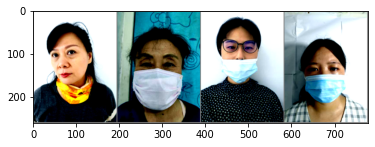

In [59]:
print(image.shape)
imshow(torchvision.utils.make_grid(image, nrow=4))
print(image.shape)
print((torchvision.utils.make_grid(image)).shape)
print("".join("%5s "%label[j] for j in range(1)))

In [61]:
# train_set, val_set = mask_dataset.split_dataset()

AttributeError: 

In [52]:
class BaseModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = self.avgpool(x)
        x = x.view(-1, 128)
        return self.fc(x)



In [65]:
device = torch.device('cuda')

In [66]:
model = BaseModel(num_classes=18).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(model.parameters(),lr=1e-3)

In [67]:
model.eval()

BaseModel(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=18, bias=True)
)

In [74]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [85]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


In [86]:
print ("Start training.")
EPOCHS,print_every = 10,1

for epoch in range(EPOCHS):
    model.train() # to train mode 
    loss_val_sum = 0
    for batch_in,batch_out in mask_loader:
        # Forward path
        y_pred = model.forward(batch_in.to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        # FILL IN HERE      # reset gradient 
        optm.zero_grad()
        # FILL IN HERE      # backpropagate
        loss_out.backward()
        # FILL IN HERE      # optimizer update
        optm.step()
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(mask_loader)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(model,mask_loader,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] ."%
               (epoch,loss_val_avg,train_accr))
print ("Done")

Start training.
epoch:[0] loss:[1.204] train_accr:[0.681] .
epoch:[1] loss:[1.017] train_accr:[0.709] .
epoch:[2] loss:[0.905] train_accr:[0.690] .
epoch:[3] loss:[0.833] train_accr:[0.733] .
epoch:[4] loss:[0.758] train_accr:[0.777] .
epoch:[5] loss:[0.702] train_accr:[0.784] .
epoch:[6] loss:[0.669] train_accr:[0.776] .
epoch:[7] loss:[0.622] train_accr:[0.818] .
epoch:[8] loss:[0.585] train_accr:[0.775] .
epoch:[9] loss:[0.557] train_accr:[0.805] .
Done


In [71]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [72]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'
image_dir = os.path.join(test_dir, 'images')
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))

In [88]:
# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((256, 192), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
# accc = func_eval(model,loader,device)        
# print ("test_accr:[%.3f] ."%
#                (accc))
submission['ans'] = all_predictions
# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')


test inference is done!


In [ ]:
EPOCHS,print_every = 10,1

for epoch in range(EPOCHS):
    model.train() # to train mode 
    loss_val_sum = 0
    for batch_in,batch_out in mask_loader:
        # Forward path
        y_pred = model.forward(batch_in.to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        # FILL IN HERE      # reset gradient 
        optm.zero_grad()
        # FILL IN HERE      # backpropagate
        loss_out.backward()
        # FILL IN HERE      # optimizer update
        optm.step()
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(mask_loader)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(model,mask_loader,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] ."%
               (epoch,loss_val_avg,train_accr))
print ("Done")